In [1]:
%matplotlib notebook 

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad

import scipy.optimize
import matplotlib.pyplot as plot

In [2]:
import matplotlib
matplotlib.rc('text', usetex=True)

In [3]:
numpy.random.seed(1234)

In [4]:
# data set generation
n_dim = 2
n_mean = numpy.array([0., -1.])
n_cov = numpy.diag([0.2, .5])
p_mean = numpy.array([1., 1.])
p_cov = numpy.diag([.5, .3])

# generate postive examples
n_pos = 50
pos_y = numpy.ones(n_pos) 
pos_x = npr.randn(n_pos, n_dim) * numpy.diag(p_cov)[None, :] + p_mean[None,:]
# generate negative examples
n_neg = 50
neg_y = -numpy.ones(n_neg)
neg_x = npr.randn(n_neg, n_dim) * numpy.diag(n_cov)[None, :] + n_mean[None,:]
# combine them
y = numpy.concatenate([pos_y, neg_y])
x = numpy.concatenate([pos_x, neg_x], axis=0)
# shuffle them
si = npr.permutation(n_pos + n_neg)
y = y[si]
x = x[si]

# grab training examples
n_tra = numpy.round(0.5 * (n_pos + n_neg)).astype(numpy.int)

y_tra = y[:n_tra]
x_tra = x[:n_tra]

y_tes = y[n_tra:]
x_tes = x[n_tra:]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [5]:
def svm(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return numpy.sign(y)

In [6]:
def svm_dist(y, x, w, avg=False, pre=False):
    y_ = svm(x, w, pre=True)
    if pre:
        return 1. - y_ * y
    d = numpy.maximum(0., 1. - y_ * y)
    
    if not avg:
        return d
    return numpy.mean(d)

In [7]:
def cost(w, x, y):
    return svm_dist(y, x, w, avg=True)

svm_rule = grad(cost)

In [8]:
def _svm_dist(w, x, y, avg=False):
    return svm_dist(y, x, w, avg=avg), svm_rule(w, x, y)

In [9]:
w0 = 1e-4 * npr.randn(n_dim+1); w0[-1] = 0.
w = numpy.copy(w0)

res = scipy.optimize.minimize(_svm_dist, w0, (x_tra, y_tra, False), 
                              method='L-BFGS-B', jac=True, options={'maxls': 100})

In [10]:
print res
w = res.x

      fun: array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.24654561,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.29995394,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.0027776 ,  0.00259303,  0.04      ])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 205
      nit: 4
   status: 2
  success: False
        x: array([ 1.84370971,  1.69083506, -0.96438

In [11]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
    plot.hold('on')
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == -1 else c+'+')
    plot.hold('off')
    plot.grid('on')

In [12]:
def vis_hyperplane(w, typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    m0, m1 = lim0[0], lim0[1]

    intercept0 = -(w[0] * m0 + w[-1])/w[1]
    intercept1 = -(w[0] * m1 + w[-1])/w[1]
    
    plt1, = plot.plot([m0, m1], [intercept0, intercept1], typ)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

In [13]:
def vis_sv(w):
    d = svm_dist(y_tra, x_tra, w, pre=True)
    
    plot.hold('on')
    
    for dd, xx in zip(d, x_tra):
        if dd >= 0.:
            plot.plot(xx[0], xx[1], '*')
    
    plot.hold('off')

<IPython.core.display.Javascript object>


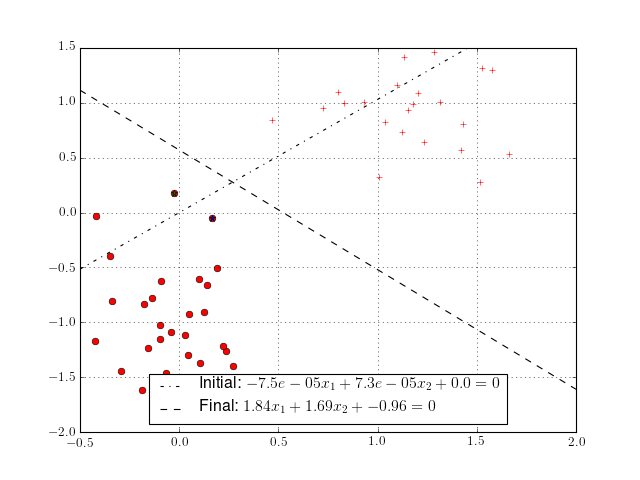

In [14]:
plot.figure()

vis_data(x_tra, y_tra, c='r')
#vis_data(x_tes, y_tes, c='b')
vis_sv(w)

plt0 = vis_hyperplane(w0, 'k-.')
plt1 = vis_hyperplane(w, 'k--')
plot.legend([plt0, plt1], [
        'Initial: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w0)),
        'Final: ${:.2f} x_1 + {:.2f} x_2 + {:.2f} = 0$'.format(*list(w))],
           loc='best')

plot.show()

In [15]:
tra_er = numpy.sum(numpy.abs(svm(x_tra, w) - y_tra)) / numpy.float(len(y_tra))
tes_er = numpy.sum(numpy.abs(svm(x_tes, w) - y_tes)) / numpy.float(len(y_tes))

print 'Training error rate {}, Test error rate {}'.format(tra_er, tes_er)

Training error rate 0.0, Test error rate 0.0
